In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, re, pickle, glob
# import zipfile
import IPython.display as ipd
import librosa
%pip install praat-parselmouth


from tqdm import tqdm
import urllib.request


Note: you may need to restart the kernel to use updated packages.


### Read the data 

In [3]:
# story path
story_directory_path = 'content/stories_data/'

# Use glob to find all .wav files in the specified directory
sample_path = story_directory_path + '*.wav'
file_paths = glob.glob(sample_path)

# Display the number of files found
print(' Story Files Found: ', len(file_paths))

# ensure linux path notation is used
file_paths = [file.replace('\\','/') for file in file_paths]
    
# read the csv file into a dataframe 
story_attributes = pd.read_csv('content/story_attributes.csv')

# turn the Story_type column into a binary variable
story_attributes['Story_type'] = story_attributes['Story_type'].map({'true_story': 1, 'deceptive_story': 0})

# rename the story_type column to True_Story
story_attributes = story_attributes.rename(columns={'Story_type': 'True_story'})


 Story Files Found:  100


## Turn into 30 second snnippets 

Both randomly select or consistently select ? ? 

## Then extractg all the features you may use. 

In [47]:
# extract random segment from audio file
def extract_segment(file_path, random=True):
    print(file_path)
    segment_duration = 30
    audio, sample_rate = librosa.load(file_path)
    # print('sample_rate: ', sample_rate)
    
    # randomly create a start time
    if random:
        start_time = np.random.randint((len(audio) / sample_rate) - segment_duration)
        # print(start_time)
    else:
        start_time = 0

    start_index = int(start_time * sample_rate)
    end_index = start_index + int(segment_duration * sample_rate)
    segment = audio[start_index:end_index]
    return segment, sample_rate
        
from parselmouth.praat import call
import parselmouth

# build function that turns features and labels into a dataframe
def build_matrices(file_paths, story_attributes):
    
    counter = 0
    y = []
    X = pd.DataFrame(columns=[
        'fileID',
        'power',
        'pitch_mean', 
        'pitch_std', 
        'energy_mean', 
        'energy_std', 
        # 'mfccs_mean', 
        # 'mfccs_std', 
        # 'jitter',
        'shimmer_mean', 
        'shimmer_std'
    ])
    # iterate through the files and build the X and y matrices
    for file in file_paths:
        fileID = file.split('/')[-1]
        
        # store the files truth label (y)
        yi = story_attributes.loc[story_attributes['filename'] == fileID, 'True_story'].values[0]
        y.append(yi)

        # extract the audio segment
        audio_segment, sample_rate = extract_segment(file)

        # ACCOUSTIC FEATURES   
             
        # Pitch and voiced region fraction 
        f0, voiced_flag, voiced_probs = librosa.pyin(y=audio_segment, fmin=65, fmax=300, sr=sample_rate) 
        pitch_mean = np.mean(f0[voiced_flag]) # only the voiced frames are considered
        pitch_std = np.std(f0[voiced_flag])  # only the voiced frames are considered
        voiced_fr = np.mean(voiced_flag)
        
        # Energy
        energy = librosa.feature.rms(y=audio_segment)[0]
        energy_mean = np.mean(energy)
        energy_std = np.std(energy)
        
        # power
        power = np.mean(audio_segment**2)
        
        # MFCCs
        mfccs = librosa.feature.mfcc(y=audio_segment, sr=sample_rate, n_mfcc=13)
        # print(mfccs.shape)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)
        
        # -------------------------------------------------
        
        # PHONETIC FEATURES        
            
        # Jitter and Shimmer using parselmouth
        snd = parselmouth.Sound(audio_segment, sampling_frequency=sample_rate) # turn the audio into a parselmouth object
        point_process = call(snd, "To PointProcess (periodic, cc)", 75, 500) # 75hz-500hz i used as a appropriate range for human speach 
        jitter = call(point_process, "Get jitter (local)", 0.0001, 0.02, 1.3, 1.0, 500) # Corrected parameters
        
        intensity = call(snd, "To Intensity", 75, 0)
        shimmer = intensity.values[0]
        shimmer_mean = np.mean(shimmer)
        shimmer_std = np.std(shimmer)
        
        # -------------------------------------------------
        
        # store the values in the features dict
        xi = pd.DataFrame([{
            'fileID': fileID,
            'power': power,
            'voiced_fr': voiced_fr,
            'pitch_mean': pitch_mean, 
            'pitch_std': pitch_std, 
            'energy_mean': energy_mean, 
            'energy_std': energy_std, 
            'shimmer_mean': shimmer_mean, 
            'shimmer_std': shimmer_std,
            **{f'mfcc_{i+1}_mean': mfccs_mean[i] for i in range(13)}, 
            **{f'mfcc_{i+1}_std': mfccs_std[i] for i in range(13)}
            }]
        )
        X = pd.concat([X, xi], axis=0)

        counter += 1
        # if counter == 10: break
        
    # add the y list as a coumn in the X df
    X['y'] = y

    return X

df = build_matrices(file_paths, story_attributes)

# set the index as the fileId
df.set_index('fileID', inplace=True)
df



content/stories_data/00001.wav


C:\Users\kasey\AppData\Local\Temp\ipykernel_22132\584728583.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X = pd.concat([X, xi], axis=0)


content/stories_data/00002.wav
content/stories_data/00003.wav
content/stories_data/00004.wav
content/stories_data/00005.wav
content/stories_data/00006.wav
content/stories_data/00007.wav
content/stories_data/00008.wav
content/stories_data/00009.wav
content/stories_data/00010.wav
content/stories_data/00011.wav
content/stories_data/00012.wav
content/stories_data/00013.wav
content/stories_data/00014.wav
content/stories_data/00015.wav
content/stories_data/00016.wav
content/stories_data/00017.wav
content/stories_data/00018.wav
content/stories_data/00019.wav
content/stories_data/00020.wav
content/stories_data/00021.wav
content/stories_data/00022.wav
content/stories_data/00023.wav
content/stories_data/00024.wav
content/stories_data/00025.wav
content/stories_data/00026.wav
content/stories_data/00027.wav
content/stories_data/00028.wav
content/stories_data/00029.wav
content/stories_data/00030.wav
content/stories_data/00031.wav
content/stories_data/00032.wav
content/stories_data/00033.wav
content/

,power,pitch_mean,pitch_std,energy_mean,energy_std,shimmer_mean,shimmer_std,voiced_fr,mfcc_1_mean,mfcc_2_mean,...,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,mfcc_12_std,mfcc_13_std,y
fileID,,,,,,,,,,,,,,,,,,,,,
00001.wav,0.000263,226.665513,28.043232,0.012323,0.010538,45.142699,18.823600,0.684985,-508.511322,94.526627,...,22.897110,22.962769,21.395803,14.499343,14.670868,14.562572,10.410283,10.789965,12.275873,0
00002.wav,0.000454,105.702531,12.476660,0.016031,0.014035,50.972524,13.404108,0.538700,-420.273712,111.640335,...,26.874702,22.374529,14.194423,12.285000,14.801142,10.756521,13.355306,10.618604,9.385201,1
00003.wav,0.018961,212.684973,27.172176,0.101564,0.092980,62.062511,18.724779,0.648607,-329.261810,111.200752,...,24.913639,22.131968,17.879227,14.382337,12.814678,12.680691,10.945799,11.914934,10.944614,0
00004.wav,0.001672,134.576929,16.878878,0.026272,0.031266,39.752539,27.306171,0.375387,-467.592590,81.230637,...,21.736752,16.538099,13.491582,12.775733,13.174662,10.589024,8.740718,9.191872,8.388440,0
00005.wav,0.000291,212.297668,33.956720,0.011752,0.012353,45.602389,16.968175,0.500000,-464.844055,97.879944,...,19.733828,23.498098,17.169586,15.199916,14.577394,10.842777,9.316384,8.844178,9.277436,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00096.wav,0.000736,111.910341,15.819386,0.021409,0.016628,54.805414,11.492857,0.712848,-376.339142,127.101006,...,20.913212,17.691475,14.822287,12.117216,16.889664,9.155532,11.137711,10.092706,8.335739,0
00097.wav,0.000165,129.754083,27.585490,0.008858,0.009311,34.644171,26.931132,0.450464,-549.337097,94.395279,...,26.988747,22.353142,16.055149,14.060628,14.986718,10.421717,10.878443,12.298069,8.967233,1
00098.wav,0.019074,162.278926,30.859971,0.104252,0.090345,63.011445,19.690104,0.595975,-250.352798,83.703751,...,25.711163,17.204428,22.705265,12.658942,18.186708,13.426484,15.968050,10.900449,9.212453,0


### transformation 

(100, 35)


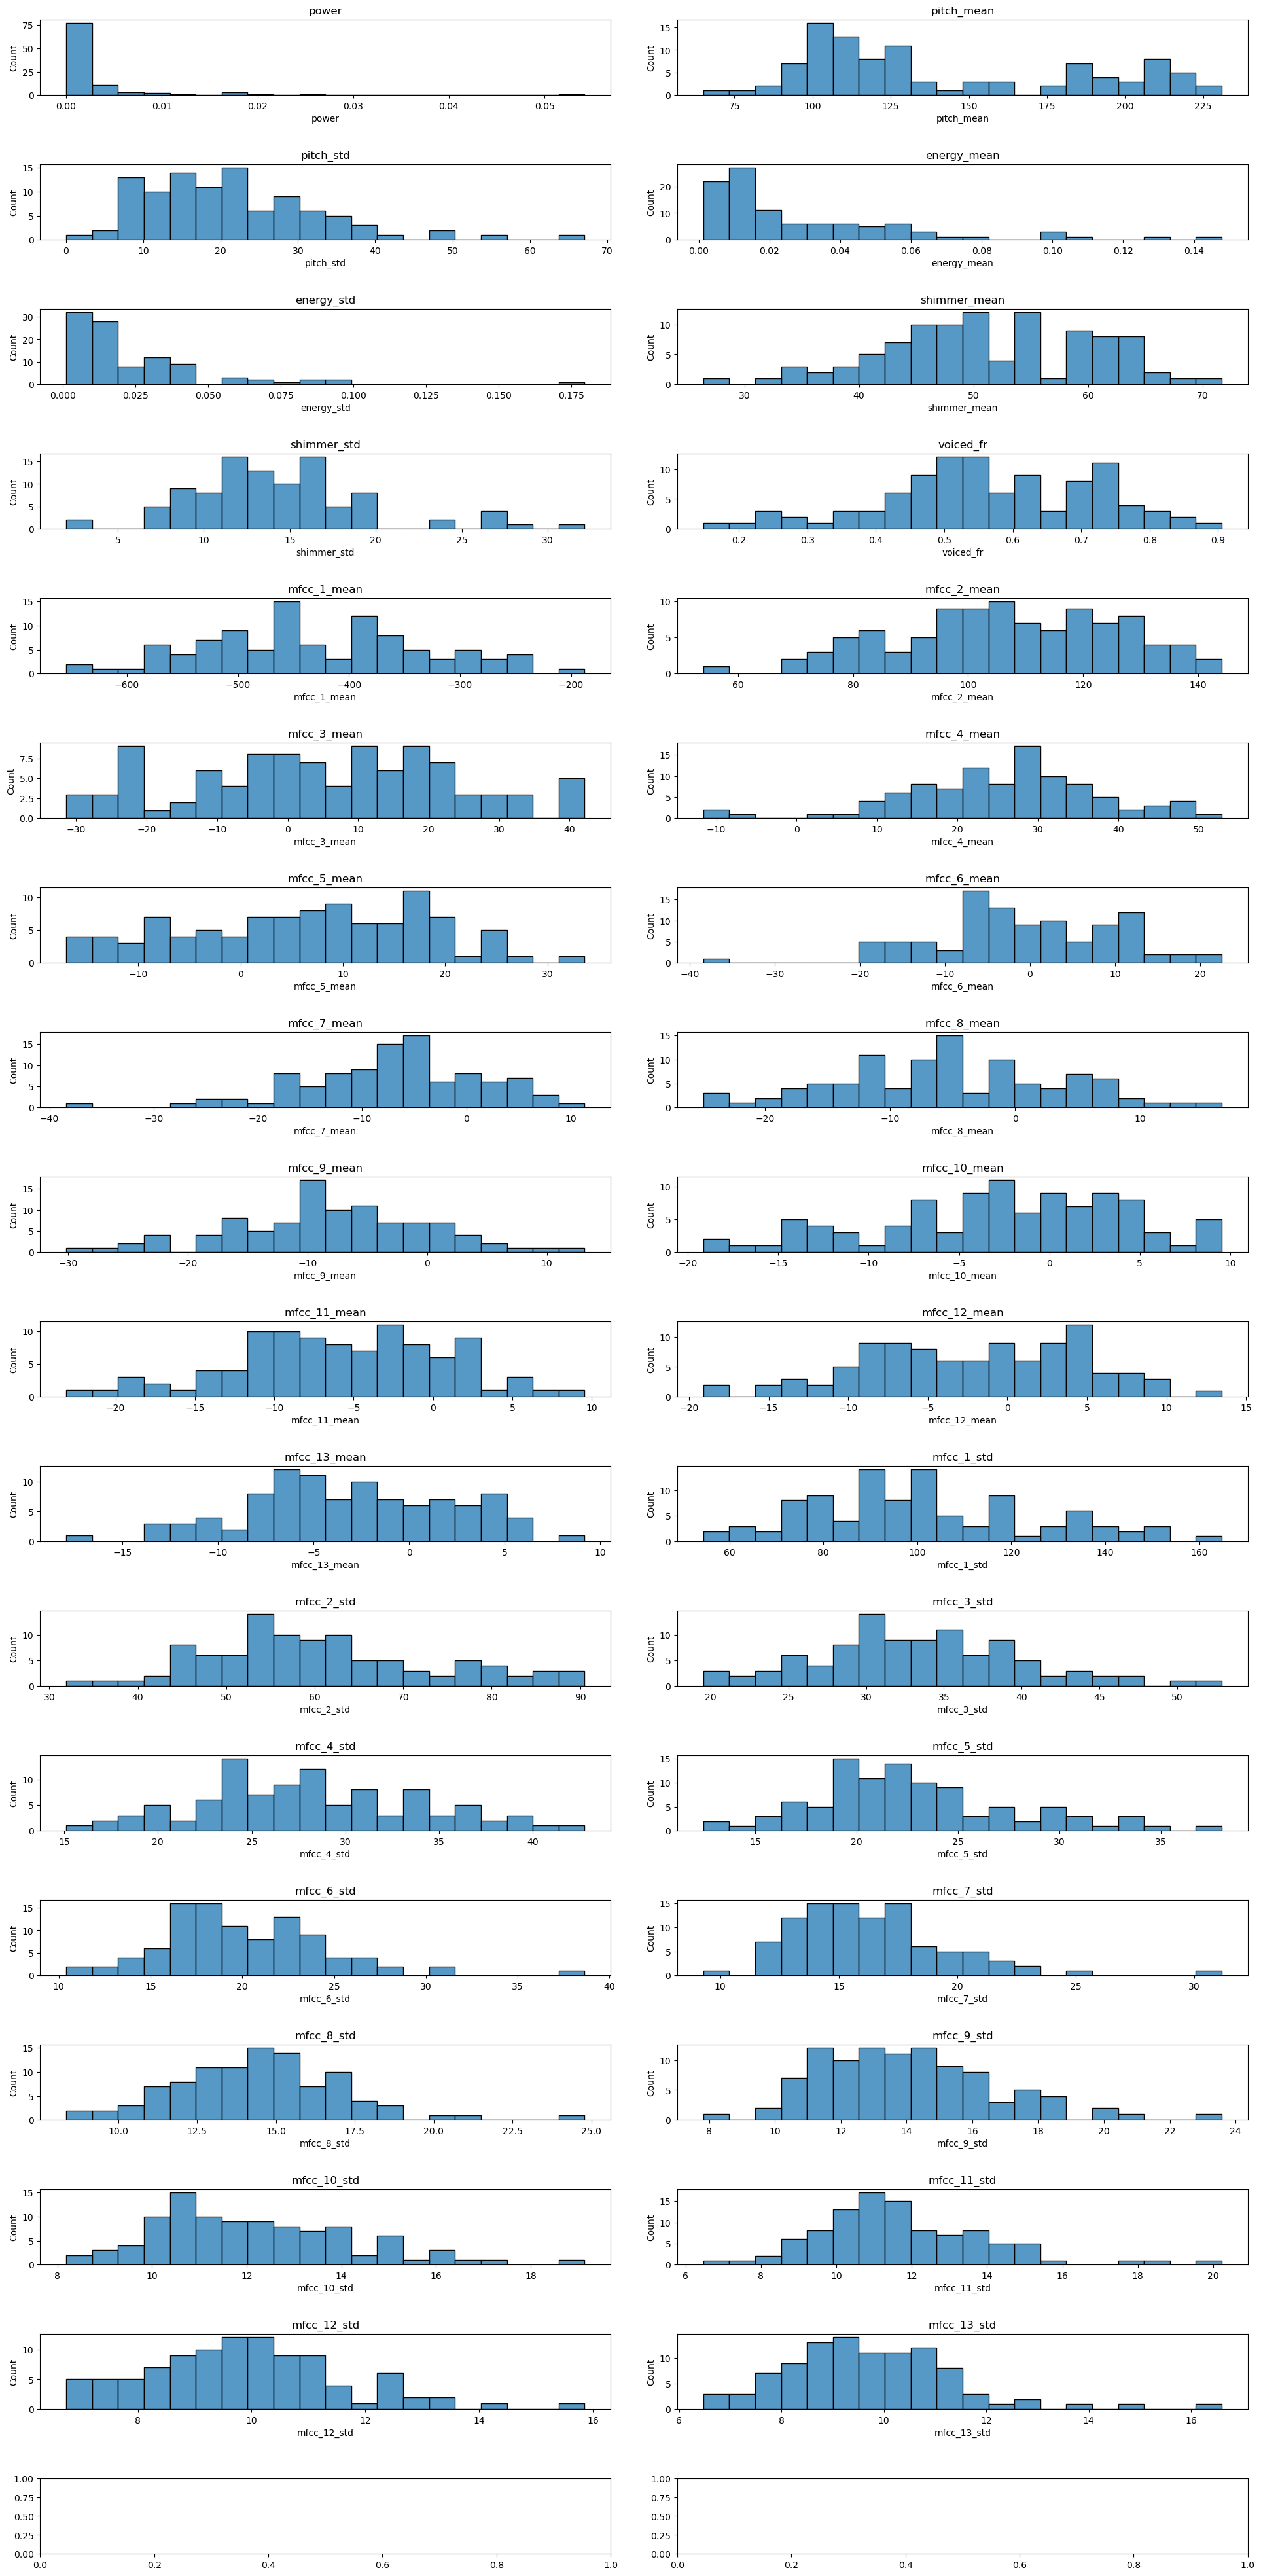

In [69]:
# count how many true stories there are in the y coukmns 
print(df.shape)



# combine X and y into a df
features = df.columns.to_list()
# create subplots for the features
fig, axs = plt.subplots(int(len(features)/2) +1, 2, figsize=(20, 40))
axs = axs.flatten()

plot_tracker = 0
for col in features:
    if col == 'y': continue
    sns.histplot(df[col], ax=axs[plot_tracker], bins=20)
    # label the plot
    axs[plot_tracker].set_title(col)
    plot_tracker += 1

plt.tight_layout(pad=3.0)

### Train the model 

In [30]:
print(X.shape)
print(y.shape)

from sklearn.model_selection import train_test_split
from sklearn import svm


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

model = svm.SVC(kernel='linear', C=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print('Training Accuracy: ', np.mean(y_pred_train == y_train))
print('Testing Accuracy: ', np.mean(y_pred_test == y_test))

(100, 6)
(100,)
Training Accuracy:  0.5571428571428572
Testing Accuracy:  0.36666666666666664


## types of performance metrixc 
1. Accuracy
Definition: The proportion of correctly classified instances among the total instances.

Use Case: Accuracy is suitable when the classes are balanced, as it gives a straightforward measure of model performance.


2. Precision
Definition: The proportion of true positive predictions among the total predicted positives.

Use Case: Useful when the cost of false positives is high.



3. Recall (Sensitivity or True Positive Rate)
Definition: The proportion of true positive predictions among the total actual positives.

Use Case: Useful when the cost of false negatives is high.


4. F1-Score
Definition: The harmonic mean of precision and recall.

Use Case: Provides a balanced measure that considers both false positives and false negatives. Useful when you want to balance precision and recall.



5. AUC-ROC (Area Under the Receiver Operating Characteristic Curve)
Definition: Measures the ability of the classifier to distinguish between classes. The ROC curve plots the true positive rate against the false positive rate at different threshold settings.

Use Case: Useful for evaluating the overall performance of the classifier across all classification thresholds.

Formula: Calculated using the ROC curve.

6. Confusion Matrix
Definition: A table that describes the performance of a classification model by showing the true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN).

Use Case: Useful for visualizing and understanding the types of errors your classifier makes.

## types of classifiers 

1. Logistic Regression
How it works: Logistic regression models the probability that an instance belongs to a particular class using the logistic function. It’s a linear model that makes its predictions based on a weighted sum of the input features.

Pros:

Easy to implement and interpret.

Works well with linearly separable data.

Fast and efficient for large datasets.

Cons:

Assumes a linear relationship between input features and the log-odds of the target.

Can struggle with complex, non-linear relationships.

2. Support Vector Machine (SVM)
How it works: SVM finds the hyperplane that best separates the two classes by maximizing the margin between them. It can use kernel functions to handle non-linear data.

Pros:

Effective in high-dimensional spaces.

Can handle non-linear relationships using the kernel trick.

Robust against overfitting, especially in high-dimensional space.

Cons:

Computationally intensive, especially for large datasets.

Requires careful tuning of parameters and choice of kernel.

3. Decision Tree
How it works: Decision trees split the data into subsets based on the most significant attribute at each node, creating a tree-like model of decisions.

Pros:

Easy to interpret and visualize.

Can handle both numerical and categorical data.

No need for feature scaling.

Cons:

Prone to overfitting, especially with deep trees.

Can be unstable because small changes in data might lead to a completely different tree.

4. Random Forest
How it works: Random forest is an ensemble method that creates multiple decision trees using random subsets of the data and features, and combines their outputs.

Pros:

Reduces the risk of overfitting compared to individual decision trees.

Handles missing values well.

Robust and generally performs well on a variety of data sets.

Cons:

Computationally intensive and can be slow for large datasets.

Less interpretable than a single decision tree.

5. K-Nearest Neighbors (KNN)
How it works: KNN classifies a data point based on the majority class among its k-nearest neighbors in the feature space.

Pros:

Simple and easy to implement.

No training phase is required.

Flexible and can handle non-linear relationships.

Cons:

Computationally expensive at prediction time.

Performance depends on the choice of k and the distance metric.

Can be sensitive to noise and irrelevant features.

6. Naive Bayes
How it works: Naive Bayes classifiers apply Bayes' theorem with the assumption that features are conditionally independent given the class label. It calculates the probability of each class and chooses the class with the highest probability.

Pros:

Fast and efficient, particularly with large datasets.

Performs well with categorical features.

Requires less training data.

Cons:

Assumes independence among features, which may not hold in practice.

Can struggle with continuous features without discretization.

7. Neural Networks
How it works: Neural networks consist of layers of interconnected neurons that learn complex patterns in the data through backpropagation and gradient descent.

Pros:

Capable of modeling complex non-linear relationships.

Highly flexible and can be used for a variety of tasks.

Performs well with large datasets and high-dimensional data.

Cons:

Requires significant computational resources.

Long training times and complex hyperparameter tuning.

Can be prone to overfitting without proper regularization.



## types of scalers 
Types of Standardization:
StandardScaler:

Transforms the data to have a mean of 0 and a standard deviation of 1.



Pros: Commonly used and effective for many ML algorithms.

Cons: Assumes that the data follows a Gaussian distribution.

MinMaxScaler:

Scales the data to a fixed range, usually [0, 1].



Pros: Preserves the relationships between data points.

Cons: Sensitive to outliers.

RobustScaler:

Uses the median and the interquartile range (IQR) to scale the data.


Pros: Robust to outliers.

Cons: Less sensitive to extreme values.

## features explanation 
Pitch
python
pitch = librosa.yin(audio_segment, fmin=50, fmax=300)
pitch_mean = np.mean(pitch)
pitch_std = np.std(pitch)
What It Is: Pitch refers to the fundamental frequency (f0) of the speech signal, which corresponds to the perceived highness or lowness of the voice.

Why It's Useful: Variations in pitch can indicate stress, nervousness, or deception. People might unintentionally raise or lower their pitch when lying. Analyzing the mean and variability (standard deviation) of pitch can help identify these changes.

2. Energy
python
energy = librosa.feature.rms(y=audio_segment)[0]
energy_mean = np.mean(energy)
energy_std = np.std(energy)
What It Is: Energy (or amplitude) measures the intensity or loudness of the speech signal.

Why It's Useful: Variations in energy can reflect emotional arousal or cognitive load. When someone is lying, they might have changes in their vocal intensity due to stress or nervousness. The mean and variability of energy provide insights into these changes.

3. Mel-Frequency Cepstral Coefficients (MFCCs)
python
mfccs = librosa.feature.mfcc(y=audio_segment, sr=sr, n_mfcc=13)
mfccs_mean = np.mean(mfccs, axis=1)
mfccs_std = np.std(mfccs, axis=1)
What It Is: MFCCs capture the short-term power spectrum of the speech signal, emphasizing the perceptually important aspects of the sound.

Why It's Useful: MFCCs are effective in capturing the timbral characteristics of speech, which can change under stress or deception. Analyzing the mean and variability of MFCCs provides detailed information about the vocal qualities of the speaker.

4. Jitter and Shimmer (Using Parselmouth)
python
snd = parselmouth.Sound(file_path)
point_process = call(snd, "To PointProcess (periodic, cc)", 75, 500)
jitter = call(point_process, "Get jitter (local)", 0, 0.02, 0.0001, 1.3)
shimmer = call(snd, "To Intensity", 75, 0)
Jitter:

What It Is: Jitter measures the frequency variation from cycle to cycle in the speech signal.

Why It's Useful: High levels of jitter can indicate stress or emotional strain, which might be present during deception. It reflects instability in the vocal frequency.
Start Time (0):

Description: This parameter specifies the start time (in seconds) for the analysis.

Default Value: 0 indicates the analysis starts from the beginning of the audio segment.

Reason: This is common to ensure the entire segment is analyzed.

Maximum Period Factor (0.02):

Description: This parameter is the maximum allowable difference between periods as a fraction of the average period.

Typical Value: 0.02 is a standard value used in many studies, corresponding to a 2% difference between periods. It helps in identifying small, local variations in pitch (jitter) that are significant.

Reason: This value is sensitive enough to capture meaningful variations without being overly restrictive.

Minimum Period (0.0001):

Description: The minimum period (in seconds) that is considered in the analysis.

Typical Value: 0.0001 seconds (or 100 microseconds) is a typical lower limit, ensuring that the analysis does not consider extremely short, potentially noise-induced variations.

Reason: This value filters out extremely high-frequency noise, focusing on realistic pitch variations in human speech.

Maximum Pitch (1.3):

Description: The maximum allowable pitch (in multiples of the minimum pitch) considered for the analysis.

Typical Value: 1.3 indicates that the analysis allows pitch variations up to 1.3 times the minimum pitch. It provides a reasonable range for detecting jitter.

Reason: This value is chosen to be broad enough to include significant pitch variations while excluding extreme outliers.

Shimmer:

What It Is: Shimmer measures the amplitude variation from cycle to cycle in the speech signal.

Why It's Useful: High levels of shimmer can also indicate stress or emotional strain, reflecting instability in the vocal amplitude. It provides complementary information to jitter.

***Imbalanced dataset >?